# Input data

In [ ]:
import pandas as pd

Hills_inter = pd.read_csv('Hills_intersections_modeling_data.csv') # you may change the file name to your own file name
Hills_inter.head()

,County_ID,Intersection_ID,Major_Roadway,Minor_Roadway,Longitude,Latitude,Crashes,legs,Major_speed_limit,Minor_speed_limit,...,straight_dec_mean,straight_dec_sum,straight_dec_max,Road,Sidewalk,Building,Vegetation,Terrain,Car,Sky
0,10,10001,10519000,10000007,-82.314509,27.853416,44,1,0,1,...,0.979015,1877.912446,4.825194,44.983368,0.533325,0.452454,6.221191,1.083618,0.954193,0.025330
1,10,10009,10508000,10000019,-82.243774,27.893678,54,1,1,1,...,0.872370,1111.826561,4.218497,43.310333,0.432495,0.640991,14.809113,2.672729,1.350861,0.028259
2,10,10011,10000020,10000606,-82.631277,28.070283,41,0,1,1,...,0.929404,977.582907,4.651345,38.748962,0.545868,0.993652,7.795105,1.832581,5.945587,0.006104
3,10,10014,10000030,10000035,-82.493688,27.911463,11,1,0,0,...,0.992624,492.577655,3.540841,38.163055,3.258667,6.461243,17.657471,1.393860,0.688324,0.001648
4,10,10015,10000030,10000056,-82.493311,27.937465,21,1,0,0,...,0.959392,807.440396,3.586964,41.671234,2.115112,2.996399,15.575897,1.204498,0.731171,0.015991


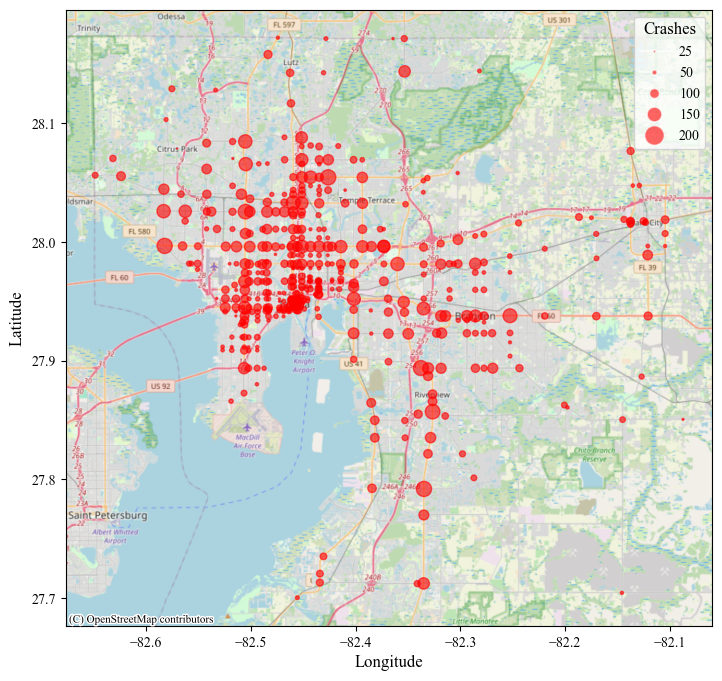

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.lines import Line2D
from shapely.geometry import Point
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

gdf = gpd.GeoDataFrame(Hills_inter, geometry=[Point(xy) for xy in zip(Hills_inter['Longitude'], Hills_inter['Latitude'])])
gdf.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(ax=ax, marker='o', color='red', markersize=gdf['Crashes']*0.5, alpha=0.6)
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

legend_sizes = [25, 50, 100, 150, 200]
legend_labels = [f"{size}" for size in legend_sizes]
legend_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=size*0.07, alpha=0.6, label=label)
    for size, label in zip(legend_sizes, legend_labels)
]
ax.legend(handles=legend_handles, title="Crashes", loc='upper right', fontsize=10, title_fontsize=12)

ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

plt.show()

## Intersection crash spatial autocorrelation test

In [3]:
import PyGML

bandwidth, local_weight, p_value, bandwidth_list, moran_I_list, z_score_list, p_value_list = PyGML.search_bw_lw_ISA(Hills_inter['Crashes'], Hills_inter[['Longitude', 'Latitude']])

c:\Users\Lei Han\.conda\envs\pytorch\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 180 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
c:\Users\Lei Han\.conda\envs\pytorch\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 31 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
c:\Users\Lei Han\.conda\envs\pytorch\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 9 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
c:\Users\Lei Han\.conda\envs\pytorch\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


bandwidth: 105, moran's I: 0.10761372543992827, p-value: 1.1131130724104743e-118


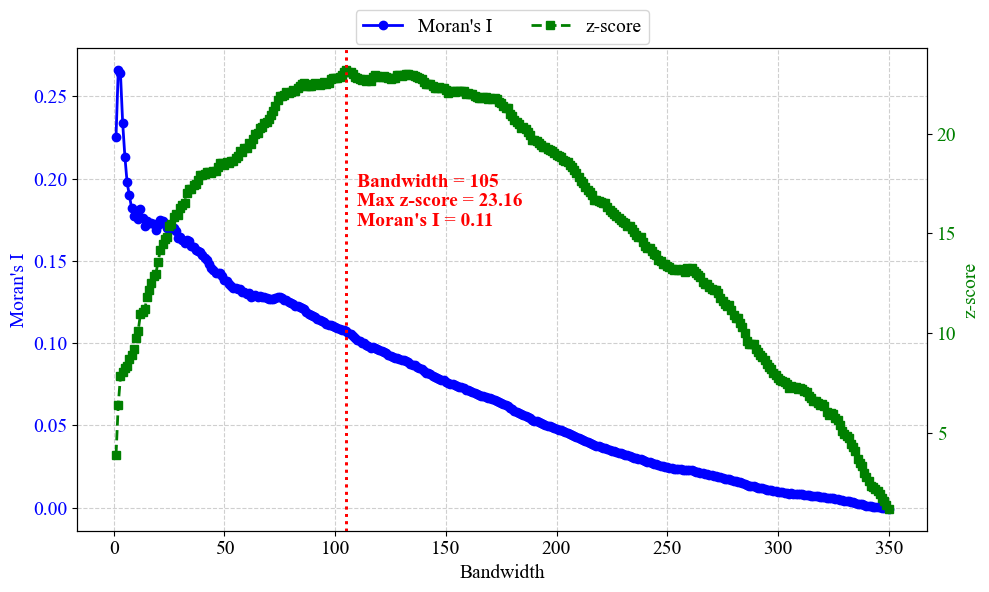

In [ ]:
filtered_indices = [i for i, bw in enumerate(bandwidth_list) if 0 <= bw <= 350]
bandwidth_list = [bandwidth_list[i] for i in filtered_indices]
moran_I_list = [moran_I_list[i] for i in filtered_indices]
z_score_list = [z_score_list[i] for i in filtered_indices]

max_z_score = max(z_score_list)
max_z_score_bandwidth = bandwidth_list[z_score_list.index(max_z_score)]
best_moran_I = moran_I_list[z_score_list.index(max_z_score)]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Moran's I
ax1.plot(bandwidth_list, moran_I_list, label="Moran's I", marker='o', linestyle='-', linewidth=2, color='b')
ax1.set_xlabel("Bandwidth", fontsize=14)
ax1.set_ylabel("Moran's I", fontsize=14, color='b')
ax1.tick_params(axis='y', labelcolor='b', labelsize=14)
ax1.tick_params(axis='x', labelsize=14)


# z-score
ax2 = ax1.twinx()
ax2.plot(bandwidth_list, z_score_list, label="z-score", marker='s', linestyle='--', linewidth=2, color='g')
ax2.set_ylabel("z-score", fontsize=14, color='g')
ax2.tick_params(axis='y', labelcolor='g', labelsize=14)

ax1.axvline(x=max_z_score_bandwidth, color='r', linestyle=':', linewidth=2)
ax2.axvline(x=max_z_score_bandwidth, color='r', linestyle=':', linewidth=2)

ax1.text(max_z_score_bandwidth + 5, max(moran_I_list) * 0.70, 
         f"Bandwidth = {max_z_score_bandwidth}\nMax z-score = {max_z_score:.2f}\nMoran's I = {best_moran_I:.2f}",
         color='r', fontsize=14, ha='left', va='center', fontweight='bold')

ax1.grid(True, linestyle='--', alpha=0.6)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper center', fontsize=14, ncol=2, bbox_to_anchor=(0.5, 1.10))

fig.tight_layout()

plt.show()

# Spatial ML modeling

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time

Hills_updated = Hills_inter.dropna(how='any').reset_index(drop=True)

# Convert categorical columns to category data type
categorical_cols = [col for col in Hills_updated.columns if Hills_updated[col].nunique() < 10]
for col in categorical_cols:
    Hills_updated[col] = Hills_updated[col].astype('category')

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    Hills_updated[col] = le.fit_transform(Hills_updated[col].astype(str))
    label_encoders[col] = le

# Define variable lists
geometric_design_vars = [
    'legs', 'Major_speed_limit', 'Minor_speed_limit', 'Major_lanes', 'Minor_lanes',
    'Major_surface_width', 'Minor_surface_width', 'Major_median_type', 'Minor_median_type',
    'Major_outshoulder_type', 'Minor_outshoulder_type', 'Major_road_class', 'Minor_road_class', 'Context_Class'
]

socioeconomic_vars = [
    'Population', 'P_Over65', 'P_Under17', 'P_Unemployed', 'P_Poverty',
    'P_Disability', 'P_Mobile_Homes', 'P_Nocar', 'Commute_Time', 'Transit_Services',
]

traffic_flow_vars = [
    'Log_Major_AADT', 'Log_Minor_AADT', 
]

driving_behavior_vars = [
        f'hard_acceleration_count', f'hard_brake_count', 
        f'hard_left_turn_count', f'hard_right_turn_count', 
        f'right_speed_std_max', 
        f'right_acc_sum', f'right_acc_max', 
        f'right_dec_sum', f'right_dec_max', 
        f'right_radial_acc_mean', f'right_radial_acc_sum', f'right_radial_acc_max',
        f'left_speed_std_max', 
        f'left_acc_sum', f'left_acc_max', 
        f'left_dec_sum', f'left_dec_max', 
        f'left_radial_acc_sum', f'left_radial_acc_max',
        f'straight_speed_std_max', 
        f'straight_acc_sum', f'straight_acc_max', 
        f'straight_dec_sum', f'straight_dec_max'
    ]

visual_environment_vars = [
    'Road', 'Sidewalk', 'Building', 'Vegetation', 'Terrain', 'Sky', 'Car'
]

# Spatial ML models:
# Spatial RF: 
# model = PyGML.PyGRFBuilder(n_estimators=60, max_features=1/3, band_width=105, train_weighted=True, predict_weighted=True, bootstrap=False,
#                           resampled=True, random_state=42)

# Spatial XGBoost: 
# model = PyGML.PyGBoostBuilder( model_type="xgboost", n_estimators=50, band_width=105, learning_rate=0.3, train_weighted=True, predict_weighted=True, 
#                               resampled=True, random_state=42) # "xgboost" & "lightgbm" seed = 2023

# Spatial LightGBM:
model = PyGML.PyGBoostBuilder( model_type="lightgbm", n_estimators=50, band_width=105, learning_rate=0.2, train_weighted=True, predict_weighted=True, 
                              resampled=True, random_state=42 ) 

# Define model inputs and outputs
X = Hills_updated[geometric_design_vars + socioeconomic_vars + traffic_flow_vars + driving_behavior_vars]
X_Coord = Hills_updated[['Longitude', 'Latitude']]
y = Hills_updated['Crashes']

# Set up 5-fold cross-validation
cv = 5
kf = KFold(n_splits=cv, shuffle=True, random_state=42) # results maybe different if you change the random_state

# Lists to store metrics for each fold
rmse_scores = []
mae_scores = []
r2_scores = []
training_times = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    print("5-fold index:", i) 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    X_Coord_train, X_Coord_test = X_Coord.iloc[train_index], X_Coord.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Record training start time
    start_time = time.time()
    model.fit(X_train, y_train, X_Coord_train)
    end_time = time.time()
    training_times.append(end_time - start_time)
    
    # Predict on test set; adjust local_weight as needed
    y_pred, predict_global, predict_local = model.predict(X_test, X_Coord_test, local_weight=0.11)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Print metrics for the current fold
    print('RMSE:', rmse)
    print('MAE:', mae)
    print('R2:', r2)
    
    # Append metrics to their respective lists
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)

# Compute mean and standard deviation for each metric
results = {
    'RMSE_Mean': np.mean(rmse_scores),
    'RMSE_Std': np.std(rmse_scores),
    'MAE_Mean': np.mean(mae_scores),
    'MAE_Std': np.std(mae_scores),
    'R2_Mean': np.mean(r2_scores),
    'R2_Std': np.std(r2_scores),
    'TrainTime_Mean': np.mean(training_times),
    'TrainTime_Std': np.std(training_times)
}

print("Final Cross-Validation Results:")
print(results)

5-fold index: 0
RMSE: 25.889961929003903
MAE: 17.84058650902539
R2: 0.5455702968729504
5-fold index: 1
RMSE: 24.874058410769535
MAE: 16.90750037977487
R2: 0.696311445181924
5-fold index: 2
RMSE: 20.465501334641917
MAE: 15.387997148302297
R2: 0.7296744837101785
5-fold index: 3
RMSE: 22.059910019584393
MAE: 15.089277594626427
R2: 0.7646120689599354
5-fold index: 4
RMSE: 25.983325209004658
MAE: 17.881876242841837
R2: 0.7574952803767288
Final Cross-Validation Results:
{'RMSE_Mean': 23.85455138060088, 'RMSE_Std': 2.2099939604576315, 'MAE_Mean': 16.621447574914164, 'MAE_Std': 1.185390330496447, 'R2_Mean': 0.6987327150203434, 'R2_Std': 0.08026843749918648, 'TrainTime_Mean': 2.4342957019805906, 'TrainTime_Std': 0.04874096077991714}


# Model Interpretation

## Global level

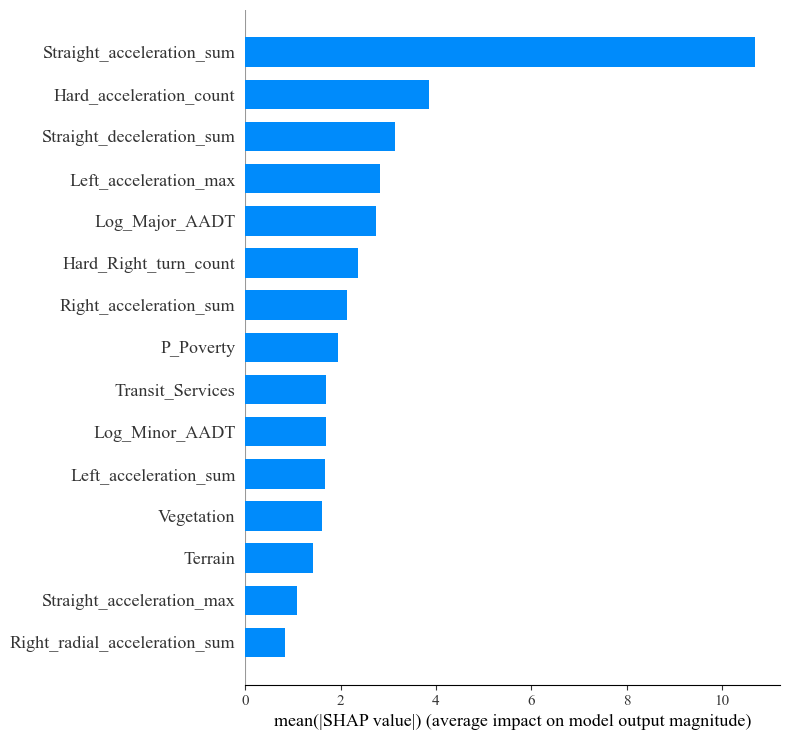

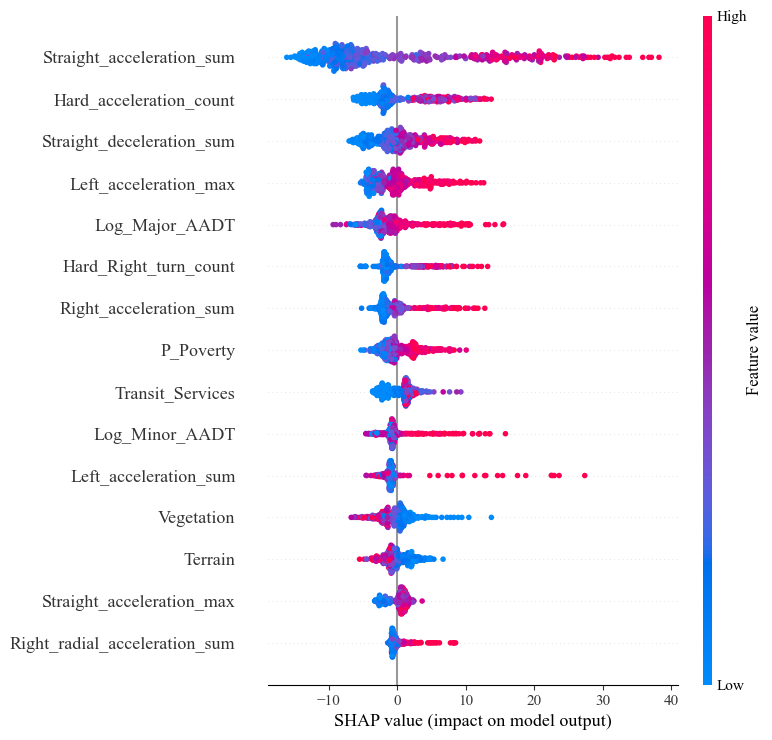

In [ ]:
import shap

model = PyGML.PyGBoostBuilder( model_type="lightgbm", n_estimators=50, band_width=105, learning_rate=0.2, train_weighted=True, predict_weighted=True, 
                              resampled=True, random_state=42) # "xgboost" & "lightgbm"

model.fit(X, y, X_Coord)

X.columns = [col.replace('_positive_acc', '_acceleration') for col in X.columns]
X.columns = [col.replace('_negative_acc', '_deceleration') for col in X.columns]
X.columns = [col.replace('_radial_acc', '_radial_acceleration') for col in X.columns]
X.columns = [col.replace('straight', 'Straight') for col in X.columns]
X.columns = [col.replace('hard', 'Hard') for col in X.columns]
X.columns = [col.replace('left', 'Left') for col in X.columns]
X.columns = [col.replace('right', 'Right') for col in X.columns]

explainer = shap.TreeExplainer(model.global_model)

shap_values = explainer.shap_values(X) 

shap.summary_plot(shap_values, X, plot_type="bar", max_display=15)

shap.summary_plot(shap_values, X, max_display=15)

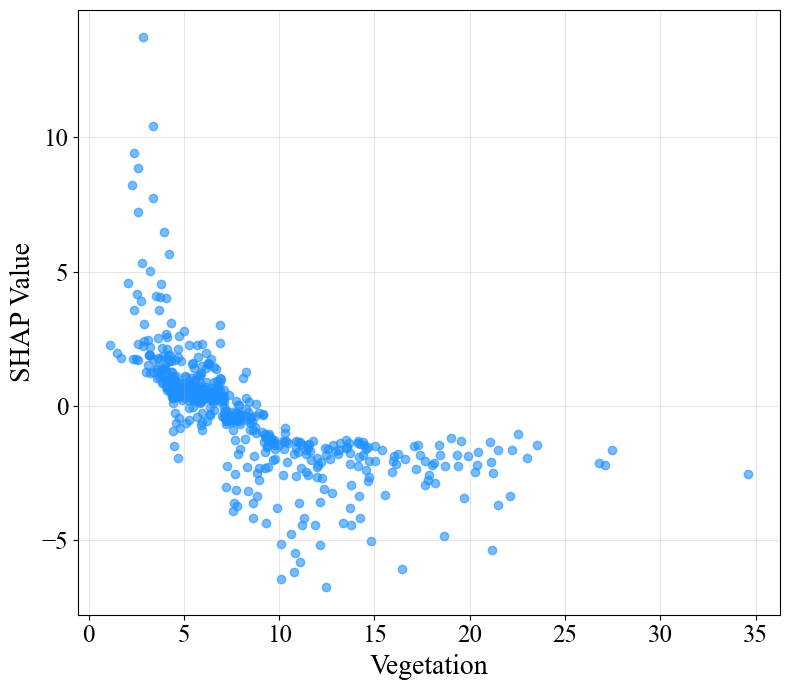

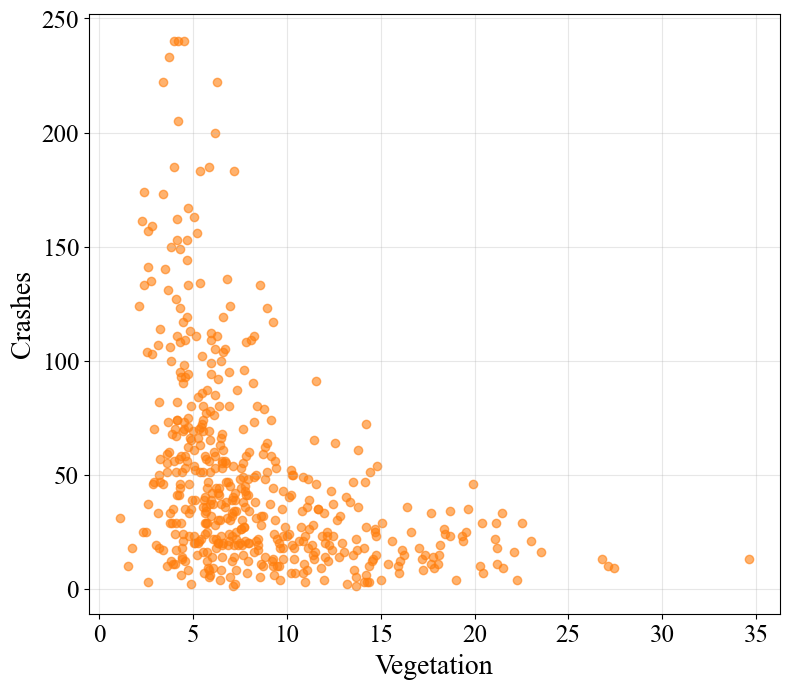

In [ ]:
import matplotlib.pyplot as plt

def plot_shap_and_scatter(feature_name, shap_values, X, target_variable):

    shap_values_for_feature = shap_values[:, X.columns.get_loc(feature_name)]
    feature_values = X[feature_name].values

    plt.figure(figsize=(8, 7))
    plt.scatter(feature_values, shap_values_for_feature, color='dodgerblue', alpha=0.6)
    plt.xlabel(feature_name, fontsize=20)
    plt.ylabel("SHAP Value", fontsize=20)
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18) 
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 7))
    plt.scatter(X[feature_name], target_variable, alpha=0.6, color='tab:orange')
    plt.xlabel(feature_name, fontsize=20)
    plt.ylabel("Crashes", fontsize=20)
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18) 
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_shap_and_scatter(
    feature_name="Vegetation", 
    shap_values=shap_values, 
    X=X, 
    target_variable=Hills_updated['Crashes_2024']
)

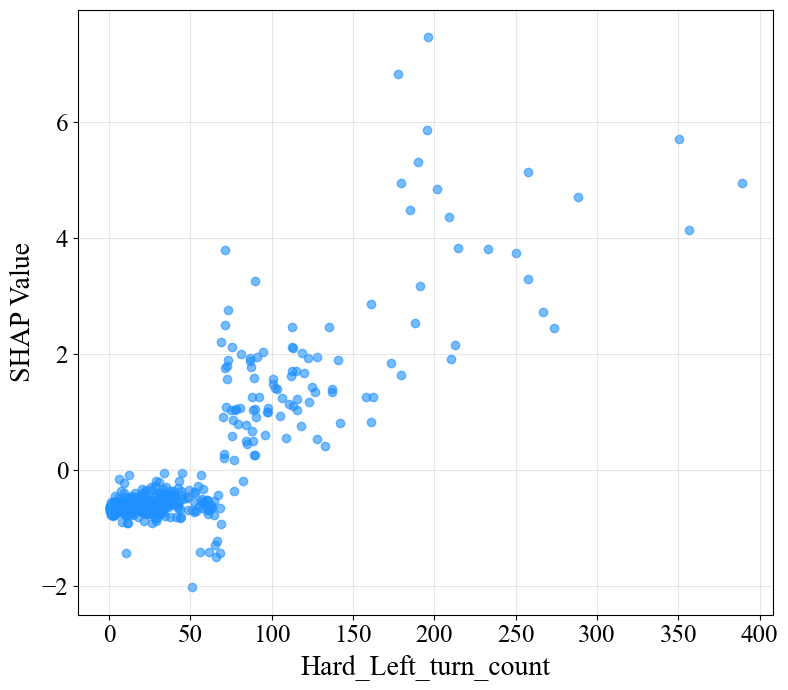

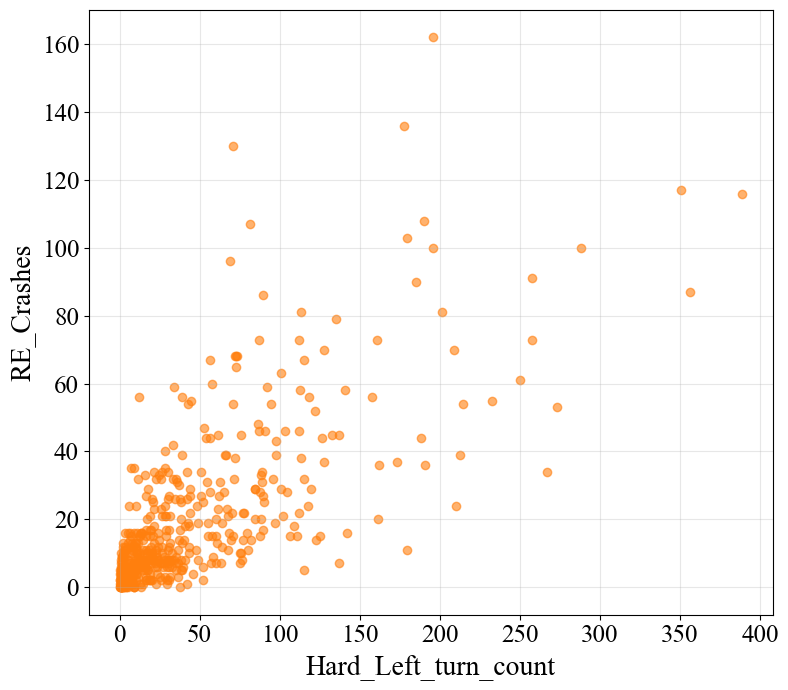

In [ ]:
import matplotlib.pyplot as plt

def plot_shap_and_scatter(feature_name, shap_values, X, target_variable):

    shap_values_for_feature = shap_values[:, X.columns.get_loc(feature_name)]
    feature_values = X[feature_name].values

    plt.figure(figsize=(8, 7))
    plt.scatter(feature_values, shap_values_for_feature, color='dodgerblue', alpha=0.6)
    plt.xlabel(feature_name, fontsize=20)
    plt.ylabel("SHAP Value", fontsize=20)
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)  
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 7))
    plt.scatter(X[feature_name], target_variable, alpha=0.6, color='tab:orange')
    plt.xlabel(feature_name, fontsize=20)
    plt.ylabel("RE_Crashes", fontsize=20)
    plt.xticks(fontsize=18)  
    plt.yticks(fontsize=18)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_shap_and_scatter(
    feature_name="Left_acceleration_max", 
    shap_values=shap_values, 
    X=X, 
    target_variable=Hills_updated['RE_Crashes_2024']
)

# Local level

In [ ]:
importance = model.get_local_feature_importance()

columns_to_normalize = importance.columns.difference(['model_index'])

importance[columns_to_normalize] = (
    importance[columns_to_normalize]
    .div(importance[columns_to_normalize].sum(axis=1), axis=0)
)

importance[['Longitude', 'Latitude']] = Hills_updated[['Longitude', 'Latitude']]
importance['Most_Important_Var'] = importance.drop(columns=['Longitude', 'Latitude','model_index']).idxmax(axis=1)

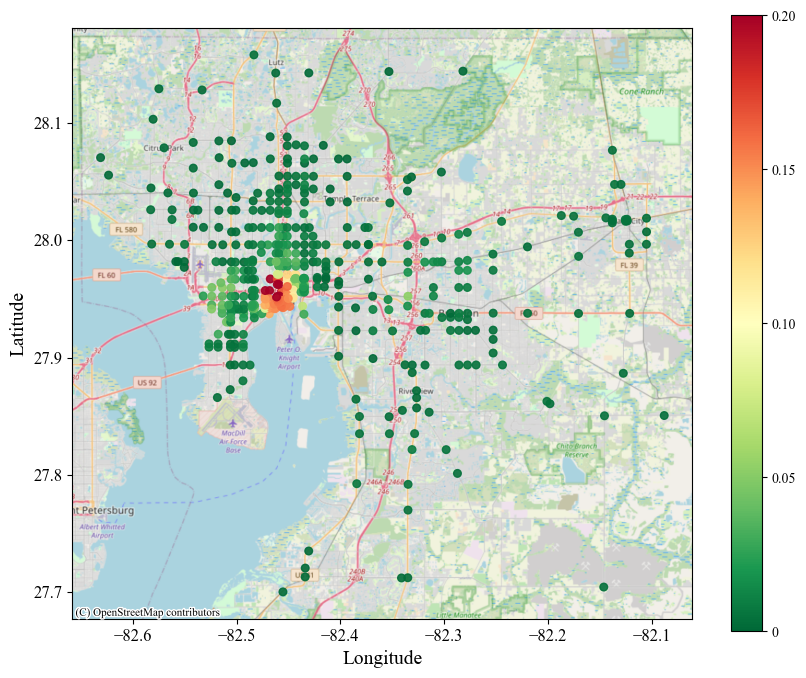

In [ ]:
from matplotlib.colors import Normalize

gdf = gpd.GeoDataFrame(
    importance,
    geometry=gpd.points_from_xy(importance['Longitude'], importance['Latitude']),
    crs="EPSG:4326" 
)

fig, ax = plt.subplots(figsize=(10, 8))
norm = Normalize(vmin=0, vmax=0.20)
plot = gdf.plot(
    column='hard_brake_count', 
    cmap='RdYlGn_r',            
    legend=True,               
    ax=ax,
    markersize=30,            
    alpha=0.9,
    norm=norm
)

cbar = plot.get_figure().axes[-1]  
cbar.set_yticks([0, 0.05, 0.10, 0.15, 0.20])  
cbar.set_yticklabels(["0", "0.05", "0.10", "0.15", "0.20"])  

ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_xlabel("Longitude", fontsize=14)  
ax.set_ylabel("Latitude", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()